## Переобучение нейронных сетей и борьба с ним

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/girafe_ai

In [1]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________

def args_and_kwargs(*args, **kwargs):
    return args, kwargs

def parse_pytorch_model(model_str):
    def parse_layer(layer_str):
        layer_name, params = layer_str.split("(", 1)
        layer_info = {"type": layer_name.strip()}
        params_template = layer_str.replace(layer_name, "args_and_kwargs")

        param_dict = {}
        if len(params):
            args, kwargs = eval(params_template)
            if len(args) or len(kwargs):
                param_dict["args"] = args
                for name, value in kwargs.items():
                    param_dict[name] = value
        layer_info["parameters"] = param_dict
        return layer_info

    model_dict = {}
    lines = model_str.splitlines()
    model_name = lines[0].strip("()")
    model_dict["model_name"] = model_name
    model_dict["layers"] = []

    layer_regex = re.compile(r"\((\d+)\): (.+)")
    for line in lines[1:]:
        line = line.strip()
        match = layer_regex.match(line)
        if match:
            index, layer = match.groups()
            model_dict["layers"].append({"index": int(index), "layer": parse_layer(layer)})
    return model_dict

# __________end of block__________

def parse_pytorch_model_FIX(model_str):
    def parse_layer(layer_str):
        layer_info = {}
        layer_name, params = layer_str.split("(", 1)
        params = params.rstrip(")")
        layer_info["type"] = layer_name.strip()
        param_dict = {}
        tmp = ''
        for param in params.split(", "):
            if "=" in param or tmp:                
                if tmp:
                    if ')' in param:
                        value = tmp + ',' + param                
                        tmp = ''
                    else:
                        tmp = tmp + ', ' + param
                        continue
                else:
                    key, value = param.split("=")
                    if '(' in value:
                        tmp = value
                        continue
                param_dict[key.strip()] = eval(value.strip())

            else:
                param_dict[param.strip()] = None
        layer_info["parameters"] = param_dict
        return layer_info

    model_dict = {}
    lines = model_str.splitlines()
    model_name = lines[0].strip("()")
    model_dict["model_name"] = model_name
    model_dict["layers"] = []

    layer_regex = re.compile(r"\((\d+)\): (.+)")
    for line in lines[1:]:
        line = line.strip()
        match = layer_regex.match(line)
        if match:
            index, layer = match.groups()
            model_dict["layers"].append({"index": int(index), "layer": parse_layer(layer)})
    return model_dict

In [3]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Загрузите файл `hw_overfitting_data_dict.npy` (ссылка есть на странице с заданием), он понадобится для генерации посылок. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).


In [4]:
!wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict -O hw_overfitting_data_dict.npy

--2025-04-23 17:34:30--  https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict [following]
--2025-04-23 17:34:31--  https://raw.githubusercontent.com/girafe-ai/ml-course/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6272446 (6.0M) [application/octet-stream]
Saving to: ‘hw_overfitting_data_dict.npy’

hw_overfitting_data 100%[===================>]   5.98M  --.-K

In [5]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

### Задача №1 (уже решённая): Создание и обучение модели (Separation)
Вы уже решали эту задачу ранее, так что сейчас просто воспроизведите своё решение. Оно понадобится вам в дальнейших шагах.
__Ваша первая задача всё та же: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__


In [6]:
CUDA_DEVICE_ID = 0  # change if needed

In [7]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

Text(0.5, 1.0, 'Image label: 3')

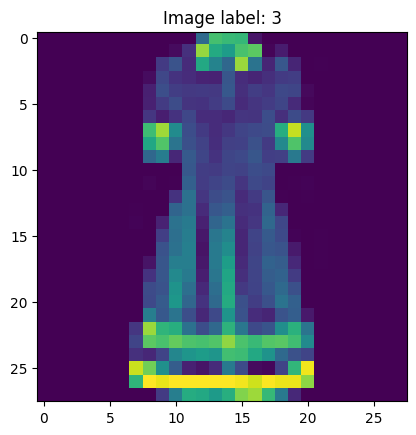

In [8]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model_task_1`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [13]:
# Creating model instance
model_task_1 = nn.Sequential(nn.Conv2d(1, 15, 3, padding=1), # 28*28
                             nn.MaxPool2d(kernel_size=2), # 14*14
                             nn.SiLU(),

                             nn.Conv2d(15, 15, 3, padding=1), # 14*14
                             nn.MaxPool2d(kernel_size=2), # 7*7
                             nn.SiLU(),

                             nn.Conv2d(15, 15, 1, padding=0), # 7*7 # padding=0 было
                             nn.SiLU(),
                             nn.Flatten(),
                             nn.Linear(7 * 7 * 15, 10),
                             #nn.SiLU(),
                             #nn.Linear(100, 10)
                             )
# your code here

Не забудьте перенести модель на выбранный `device`!

In [15]:
model_task_1.to(device)

Sequential(
  (0): Conv2d(1, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): SiLU()
  (3): Conv2d(15, 15, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): SiLU()
  (6): Conv2d(15, 15, kernel_size=(1, 1), stride=(1, 1))
  (7): SiLU()
  (8): Flatten(start_dim=1, end_dim=-1)
  (9): Linear(in_features=735, out_features=10, bias=True)
)

Локальные тесты для проверки вашей модели доступны ниже:

In [16]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [18]:
# your code here
crit = nn.CrossEntropyLoss()
lr = 1e-3
optimizer = torch.optim.Adam
epochs = 10

In [19]:
def train(model, epochs, crit, lr, optimizer):
    opt = optimizer(model.parameters(), lr=lr)
    for epoch in range(epochs):
        model.train()
        mean_train_loss = 0
        mean_train_acc = 0
        for X, label in train_data_loader:

            X, label = X.to(device), label.to(device)
            opt.zero_grad()
            output = model(X)
            loss = crit(output, label)

            loss.backward()
            opt.step()
            with torch.no_grad():
                mean_train_loss += loss
                mean_train_acc += torch.sum(torch.argmax(output, dim=1) == label, dtype=torch.float32)
        with torch.no_grad():
            mean_train_loss /= float(len(train_data_loader))
            mean_train_acc /= float(len(train_fmnist_data))

        model.eval()
        mean_test_loss = 0
        mean_test_acc = 0
        with torch.no_grad():
            for X, label in test_data_loader:
                X, label = X.to(device), label.to(device)
                output = model(X)
                loss = crit(output, label)
                mean_test_loss += loss
                mean_test_acc += torch.sum(torch.argmax(output, dim=1) == label, dtype=torch.float32)
            mean_test_loss /= len(test_data_loader)
            mean_test_acc /= len(test_fmnist_data)
        print(f'Epoch {epoch + 1} from {epochs}. \n Train loss: {mean_train_loss} \n Train accuracy: {mean_train_acc} \n Test loss: {mean_test_loss} \n Test accuracy: {mean_test_acc}')
    return model, opt

In [20]:
model_task_1, _ = train(model_task_1, epochs, crit, lr, optimizer)

Epoch 1 from 10. 
 Train loss: 0.551845908164978 
 Train accuracy: 0.7986500263214111 
 Test loss: 0.41525521874427795 
 Test accuracy: 0.8496999740600586
Epoch 2 from 10. 
 Train loss: 0.36219748854637146 
 Train accuracy: 0.8699333667755127 
 Test loss: 0.360680490732193 
 Test accuracy: 0.8718999624252319
Epoch 3 from 10. 
 Train loss: 0.3186100423336029 
 Train accuracy: 0.8860166668891907 
 Test loss: 0.32657089829444885 
 Test accuracy: 0.8811999559402466
Epoch 4 from 10. 
 Train loss: 0.2948113679885864 
 Train accuracy: 0.8933833241462708 
 Test loss: 0.3122061789035797 
 Test accuracy: 0.8892999887466431
Epoch 5 from 10. 
 Train loss: 0.2763672173023224 
 Train accuracy: 0.9002833366394043 
 Test loss: 0.3313828110694885 
 Test accuracy: 0.8797000050544739
Epoch 6 from 10. 
 Train loss: 0.264178603887558 
 Train accuracy: 0.9038000106811523 
 Test loss: 0.30076777935028076 
 Test accuracy: 0.8901000022888184
Epoch 7 from 10. 
 Train loss: 0.2540232241153717 
 Train accuracy: 0

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

Оценим качество классификации:

In [21]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.91127


In [22]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.8942


Проверка, что необходимые пороги пройдены:

In [23]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Test accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_1`.

import re
import ast

def parse_pytorch_model(model_str):
    def parse_layer(layer_str):
        layer_info = {}
        parts = layer_str.split("(", 1)
        layer_name = parts[0].strip()
        layer_info["type"] = layer_name
        
        if len(parts) == 1:
            layer_info["parameters"] = {}
            return layer_info
            
        params_str = parts[1].rstrip(")")
        param_dict = {}
        current_param = []
        in_brackets = 0
        
        for char in params_str + ",":
            if char == "(":
                in_brackets += 1
                current_param.append(char)
            elif char == ")":
                in_brackets -= 1
                current_param.append(char)
            elif char == "," and in_brackets == 0:
                param = "".join(current_param).strip()
                if param:
                    if "=" in param:
                        key, value = param.split("=", 1)
                        key = key.strip()
                        value = value.strip()
                        try:
                            param_dict[key] = ast.literal_eval(value)
                        except:
                            param_dict[key] = value
                    else:
                        param_dict[param] = None
                current_param = []
            else:
                current_param.append(char)
        
        layer_info["parameters"] = param_dict
        return layer_info

    # Обработка входных данных
    lines = [line.strip() for line in model_str.splitlines() if line.strip()]
    if not lines:
        return {"model_name": "Unknown", "layers": []}

    # Извлекаем имя модели из первой строки (новый способ)
    model_name = lines[0].split("(", 1)[0].strip()
    model_dict = {
        "model_name": model_name,
        "layers": []
    }

    # Регулярное выражение для слоев
    layer_pattern = re.compile(r"\((\w+)\):\s*(\w+)\((.*)\)")
    
    for line in lines[1:]:
        if line.startswith("(") and "):" in line:
            match = layer_pattern.match(line)
            if match:
                layer_name, layer_type, params = match.groups()
                try:
                    layer_info = parse_layer(f"{layer_type}({params})")
                    model_dict["layers"].append({
                        "name": layer_name,
                        "type": layer_type,
                        "parameters": layer_info["parameters"]
                    })
                except Exception as e:
                    print(f"Error parsing layer {layer_name}: {str(e)}")

    return model_dict

In [24]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
    "model_task_1": parse_pytorch_model(str(model_task_1)),
}

with open("submission_dict_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_task_1.json`")
# __________end of block__________

File saved to `submission_dict_task_1.json`


### Задача №2: Переобучение (Initiation)
Продолжим работу с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Теперь ваша задача продемонстрировать переобучение модели на обучающей выборке. Достаточно показать, что точность классификации (не только функция потерь!) на тестовой выборке значительно отстает от обучающей.

Обращаем ваше внимание, в задаче №3 вам придется починить данную модель (минимизировать эффект переобучения) с помощью механизмов регуляризации, поэтому не переусердствуйте!

__Ваша вторая задача: реализовать используя пайплан обучения модели продемонстрировать переобучения модели на обучающей выборке.__

Код для обучения модели вы можете переиспользовать. Далее присутствует лишь несколько тестов, которые помогут вам проверить свое решение.

Обращаем внимание, вам необходимо использовать переменную `model_task_2` для хранение модели во второй задаче.

Не используйте `Dropout` и `BatchNorm` в этой задаче

In [25]:
# Creating model instance
model_task_2 = nn.Sequential(nn.Conv2d(1, 20, 3, padding=1), # 28*28
                             nn.MaxPool2d(kernel_size=2), # 14*14
                             nn.SiLU(),

                             nn.Conv2d(20, 20, 3, padding=1), # 14*14
                             nn.SiLU(),
                             nn.Conv2d(20, 20, 3, padding=1),
                             nn.MaxPool2d(kernel_size=2), # 7*7
                             nn.SiLU(),

                             nn.Conv2d(20, 15, 1, padding=0), # 7*7
                             nn.SiLU(),
                             nn.Flatten(),
                             nn.Linear(7 * 7 * 15, 50),
                             nn.SiLU(),
                             nn.Linear(50, 10)
                             #nn.SiLU(),
                             #nn.Linear(100, 10)
                             )
# your code here

In [26]:
model_task_2.to(device)

Sequential(
  (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): SiLU()
  (3): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): SiLU()
  (5): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): SiLU()
  (8): Conv2d(20, 15, kernel_size=(1, 1), stride=(1, 1))
  (9): SiLU()
  (10): Flatten(start_dim=1, end_dim=-1)
  (11): Linear(in_features=735, out_features=50, bias=True)
  (12): SiLU()
  (13): Linear(in_features=50, out_features=10, bias=True)
)

In [27]:
model_task_2, _ = train(model_task_2, 20, crit, lr, optimizer)# your code here

Epoch 1 from 20. 
 Train loss: 0.5340753197669983 
 Train accuracy: 0.8020833134651184 
 Test loss: 0.38727426528930664 
 Test accuracy: 0.8590999841690063
Epoch 2 from 20. 
 Train loss: 0.3315041959285736 
 Train accuracy: 0.8765833377838135 
 Test loss: 0.31963950395584106 
 Test accuracy: 0.8801999688148499
Epoch 3 from 20. 
 Train loss: 0.28271645307540894 
 Train accuracy: 0.8943333625793457 
 Test loss: 0.2998596429824829 
 Test accuracy: 0.8883999586105347
Epoch 4 from 20. 
 Train loss: 0.24888809025287628 
 Train accuracy: 0.9070667028427124 
 Test loss: 0.28750181198120117 
 Test accuracy: 0.8937999606132507
Epoch 5 from 20. 
 Train loss: 0.22664637863636017 
 Train accuracy: 0.9149667024612427 
 Test loss: 0.2728121876716614 
 Test accuracy: 0.9009999632835388
Epoch 6 from 20. 
 Train loss: 0.20706142485141754 
 Train accuracy: 0.923216700553894 
 Test loss: 0.24775025248527527 
 Test accuracy: 0.9121999740600586
Epoch 7 from 20. 
 Train loss: 0.190914586186409 
 Train accura

Проверка архитектуры:

In [28]:
# do not change the code in the block below
# __________start of block__________
layers_task_2 = []
for element in parse_pytorch_model(str(model_task_2)).get("layers", []):
    layer_name = element["layer"]["type"]
    assert "dropout" not in layer_name.lower(), "Do not use Dropout in Task 2!"
    assert "batchnorm" not in layer_name.lower(), "Do not use BatchNorm in Task 2!"
    layers_task_2.append(layer_name)
# __________end of block__________

Оценим качество классификации:

In [29]:
train_acc_task_2 = get_accuracy(model_task_2, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_2:3.5}")

Neural network accuracy on train set: 0.9783


In [30]:
test_acc_task_2 = get_accuracy(model_task_2, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_2:3.5}")

Neural network accuracy on test set: 0.9123


Проверка, что переобучение присутствует:

In [31]:
assert train_acc_task_2 >= test_acc_task_2, "Train accuracy must be higher than task accuracy"
assert train_acc_task_2 >= 0.88, "Train accuracy must be higher than 0.88"
assert (
    train_acc_task_2 - test_acc_task_2 >= 0.04
), "Test accuracy should be at least 0.04 lower that train."

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_2`.

Также предполагается, что в переменной `submission_dict` уже содержатся результаты задачи №1. Если их там нет, загрузите их из сохраненного файла в переменную перед запуском следующей ячейки.

In [32]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_2": get_predictions(
            model_task_2, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_2": parse_pytorch_model(str(model_task_2)),
    }
)

with open("submission_dict_tasks_1_and_2.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_tasks_1_and_2.json`")
# __________end of block__________

File saved to `submission_dict_tasks_1_and_2.json`


### Задача №3: Исправление модели (Return)
Все так же работаем с [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). Наконец, ваша задача исправить ~~ошибки прошлого~~ переобучение модели, построенной в задаче 2. Достаточно добиться расхождения между точностью классификации на обучающей и тестовой выборках не превышающего 0.015 (т.е. полутора процентов).

Обращаем ваше внимание, архитектура модели в задаче №3 не должна существенно отличаться от задачи №2! Вы можете использовать Batchnorm, Dropout, уменьшить размерность промежуточных представлений, обратиться к аугментации данных, но вы не можете использовать меньшее количество слоёв.

__Ваша третья и финальная задача: исправить модель и/или процесс обучения, дабы справиться с переобучением.__

Код для обучения модели вы можете переиспользовать. Далее присутствует лишь несколько тестов, которые помогут вам проверить свое решение.

Обращаем внимание, вам необходимо использовать переменную `model_task_3` для хранение модели во второй задаче.

Также код ниже будет обращаться к переменной `layers_task_2`, инициализируйте её, если она не определена.

In [33]:
# do not change the code in the block below
# __________start of block__________
assert (
    layers_task_2 is not None
), "Initializa layers_task_2 vairable which contains list of layers in task 2 model"
# __________end of block__________

In [34]:
model_task_3 = nn.Sequential(nn.Conv2d(1, 20, 3, padding=1), # 28*28
                             nn.MaxPool2d(kernel_size=2), # 14*14
                             nn.SiLU(),

                             nn.Dropout(p=0.3),

                             nn.Conv2d(20, 20, 3, padding=1), # 14*14
                             nn.SiLU(),
                             nn.Conv2d(20, 20, 3, padding=1),
                             nn.MaxPool2d(kernel_size=2), # 7*7
                             nn.SiLU(),

                             nn.Conv2d(20, 15, 1, padding=0), # 7*7
                             nn.SiLU(),

                             nn.Dropout(),

                             nn.Flatten(),
                             nn.Linear(7 * 7 * 15, 50),
                             nn.SiLU(),
                             nn.Linear(50, 10)
                             )

In [35]:
model_task_3.to(device)

Sequential(
  (0): Conv2d(1, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): SiLU()
  (3): Dropout(p=0.3, inplace=False)
  (4): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): SiLU()
  (6): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): SiLU()
  (9): Conv2d(20, 15, kernel_size=(1, 1), stride=(1, 1))
  (10): SiLU()
  (11): Dropout(p=0.5, inplace=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear(in_features=735, out_features=50, bias=True)
  (14): SiLU()
  (15): Linear(in_features=50, out_features=10, bias=True)
)

In [37]:
model_task_3, _ = train(model=model_task_3, epochs=6, crit=crit, lr=lr, optimizer=optimizer) # your code here

Epoch 1 from 6. 
 Train loss: 0.6270601153373718 
 Train accuracy: 0.7618833184242249 
 Test loss: 0.4215855598449707 
 Test accuracy: 0.8427000045776367
Epoch 2 from 6. 
 Train loss: 0.41880059242248535 
 Train accuracy: 0.8426833152770996 
 Test loss: 0.36782389879226685 
 Test accuracy: 0.8606999516487122
Epoch 3 from 6. 
 Train loss: 0.3664586842060089 
 Train accuracy: 0.860966682434082 
 Test loss: 0.32269933819770813 
 Test accuracy: 0.8787999749183655
Epoch 4 from 6. 
 Train loss: 0.3383193016052246 
 Train accuracy: 0.8736667037010193 
 Test loss: 0.30514195561408997 
 Test accuracy: 0.8870999813079834
Epoch 5 from 6. 
 Train loss: 0.3142194449901581 
 Train accuracy: 0.8828666806221008 
 Test loss: 0.2892489731311798 
 Test accuracy: 0.8946999907493591
Epoch 6 from 6. 
 Train loss: 0.30057090520858765 
 Train accuracy: 0.8871999979019165 
 Test loss: 0.2713561952114105 
 Test accuracy: 0.9001999497413635


Проверка архитектуры:

In [38]:
# do not change the code in the block below
# __________start of block__________
layers_task_3 = []
for element in parse_pytorch_model(str(model_task_3)).get("layers", []):
    layer_name = element["layer"]["type"]
    layers_task_3.append(layer_name)


idx = 0
for model_3_layer in layers_task_3:
    model_2_layer = layers_task_2[idx]
    if "dropout" not in model_3_layer.lower() and "batchnorm" not in model_3_layer.lower():
        assert (
            model_3_layer == model_2_layer
        ), "Models in tasks 2 and 3 must share the architecture except for Dropout and BatchNorm!"
        idx += 1
# __________end of block__________

Оценим качество классификации:

In [39]:
train_acc_task_3 = get_accuracy(model_task_3, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_3:3.5}")

Neural network accuracy on train set: 0.91337


In [40]:
test_acc_task_3 = get_accuracy(model_task_3, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_3:3.5}")

Neural network accuracy on test set: 0.9002


Проверка, что переобучение присутствует:

In [41]:
assert train_acc_task_3 >= 0.88, "Train accuracy must be higher than 0.88"
assert train_acc_task_3 >= 0.865, "Test accuracy must be higher than 0.865"
assert (
    train_acc_task_3 - test_acc_task_3 <= 0.015
), "Test accuracy should not be lower that train more than by 0.015"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_3`.

Также предполагается, что в переменной `submission_dict` уже содержатся результаты задач №1 и №2. Если их там нет, загрузите их из сохраненных файлов перед запуском следующей ячейки.

In [42]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_overfitting_data_dict.npy", allow_pickle=True)

submission_dict.update(
    {
        "train_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["train"])
        ),
        "test_predictions_task_3": get_predictions(
            model_task_3, torch.FloatTensor(loaded_data_dict.item()["test"])
        ),
        "model_task_3": parse_pytorch_model(str(model_task_3)),
    }
)

with open("submission_dict_final.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_final.json`")
# __________end of block__________

File saved to `submission_dict_final.json`


### Сдача задания
Сдайте сгенерированные файлы в соответствующие задачи в соревновании, а именно:
* `submission_dict_tasks_1_and_2.json` в задачу Initiation
* `submission_dict_final.json` в задачу Return.


`submission_dict_task_1.json` сдавать не нужно, он уже был сдан ранее.

На этом задание завершено. Поздравляем!